In [1]:
import json
import os
import sys

sys.path.append('/home/luis/CGE/luxgiant-dstream/luxgiant_dstream')

from luxgiant_dstream.prep_ds import PrepDS
from luxgiant_dstream.gwas_fixed import GWASfixed
from luxgiant_dstream.gwas_random import GWASrandom

In [2]:
#params = json.load(open("//home/luis/data/testDownStream/configFiles/parameters.JSON"))
#paths = json.load(open("/home/luis/data/testDownStream/configFiles/paths_local.JSON"))

params = json.load(open("//home/luis/data/LuxGiantimputed/configFiles/parameters.JSON"))
paths = json.load(open("/home/luis/data/LuxGiantimputed/configFiles/paths_local.JSON"))

In [3]:
#prep = PrepDS(
#    input_path=paths['input_directory'],
#    input_name=paths['input_prefix'],
#    output_path=paths['output_directory'],
#    output_name=paths['output_prefix'],
#    config_dict=params,
#    dependables_path=paths['dependables_directory'],
#)

In [4]:
#prep_steps = {
#    'ld_prune': prep.exclude_high_ld_hla,
#    'pca'     : prep.pca_decomposition
#}
#
#for step in prep_steps.keys():
#    prep_steps[step]()

PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/luis/data/LuxGiantimputed/outputData/preparatory/ds_results_prunning.log.
Options in effect:
  --bfile /home/luis/data/LuxGiantimputed/inputData/luxgiant_imputed_noprobID
  --chr 1-22
  --exclude /home/luis/data/LuxGiantimputed/dependables/high-LD-regions.txt
  --geno 0.1
  --hwe 5e-08
  --indep-pairwise 50 5 0.2
  --maf 0.05
  --make-bed
  --out /home/luis/data/LuxGiantimputed/outputData/preparatory/ds_results_prunning
  --range
  --threads 30

Note: --range flag deprecated.  Use e.g. "--extract range <filename>".
63927 MB RAM detected; reserving 31963 MB for main workspace.
23169127 variants loaded from .bim file.
11170 people (7458 males, 3712 females) loaded from .fam.
11170 phenotype values loaded from .fam.
--exclude range: 499022 variants excluded.
--exclude range: 22670105 variants remaining.
Using 1 threa

In [3]:
gwas_f = GWASfixed(
    input_path = paths['input_directory'],
    input_name = paths['input_prefix'],
    output_path= paths['output_directory'],
    output_name= paths['output_prefix'],
    dependables= paths['dependables_directory'],
    config_dict= params,
    preps_path = os.path.join(paths['output_directory'], 'preparatory'),
)
gwas_f.compare_gwas_fixed_file_name = 'european_cohort_nallsEtAl2019_excluding23andMe_allVariants.hg38.tsv'

Analysis of GWAS data using a fixed model initialized.


/home/luis/CGE/luxgiant-dstream/luxgiant_dstream/plots.py:360: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=plot_data['upper']['rel_pos'], y=plot_data['upper']['log10p'],
/home/luis/CGE/luxgiant-dstream/luxgiant_dstream/plots.py:402: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=plot_data['lower']['rel_pos'], y=plot_data['lower']['log10p'],


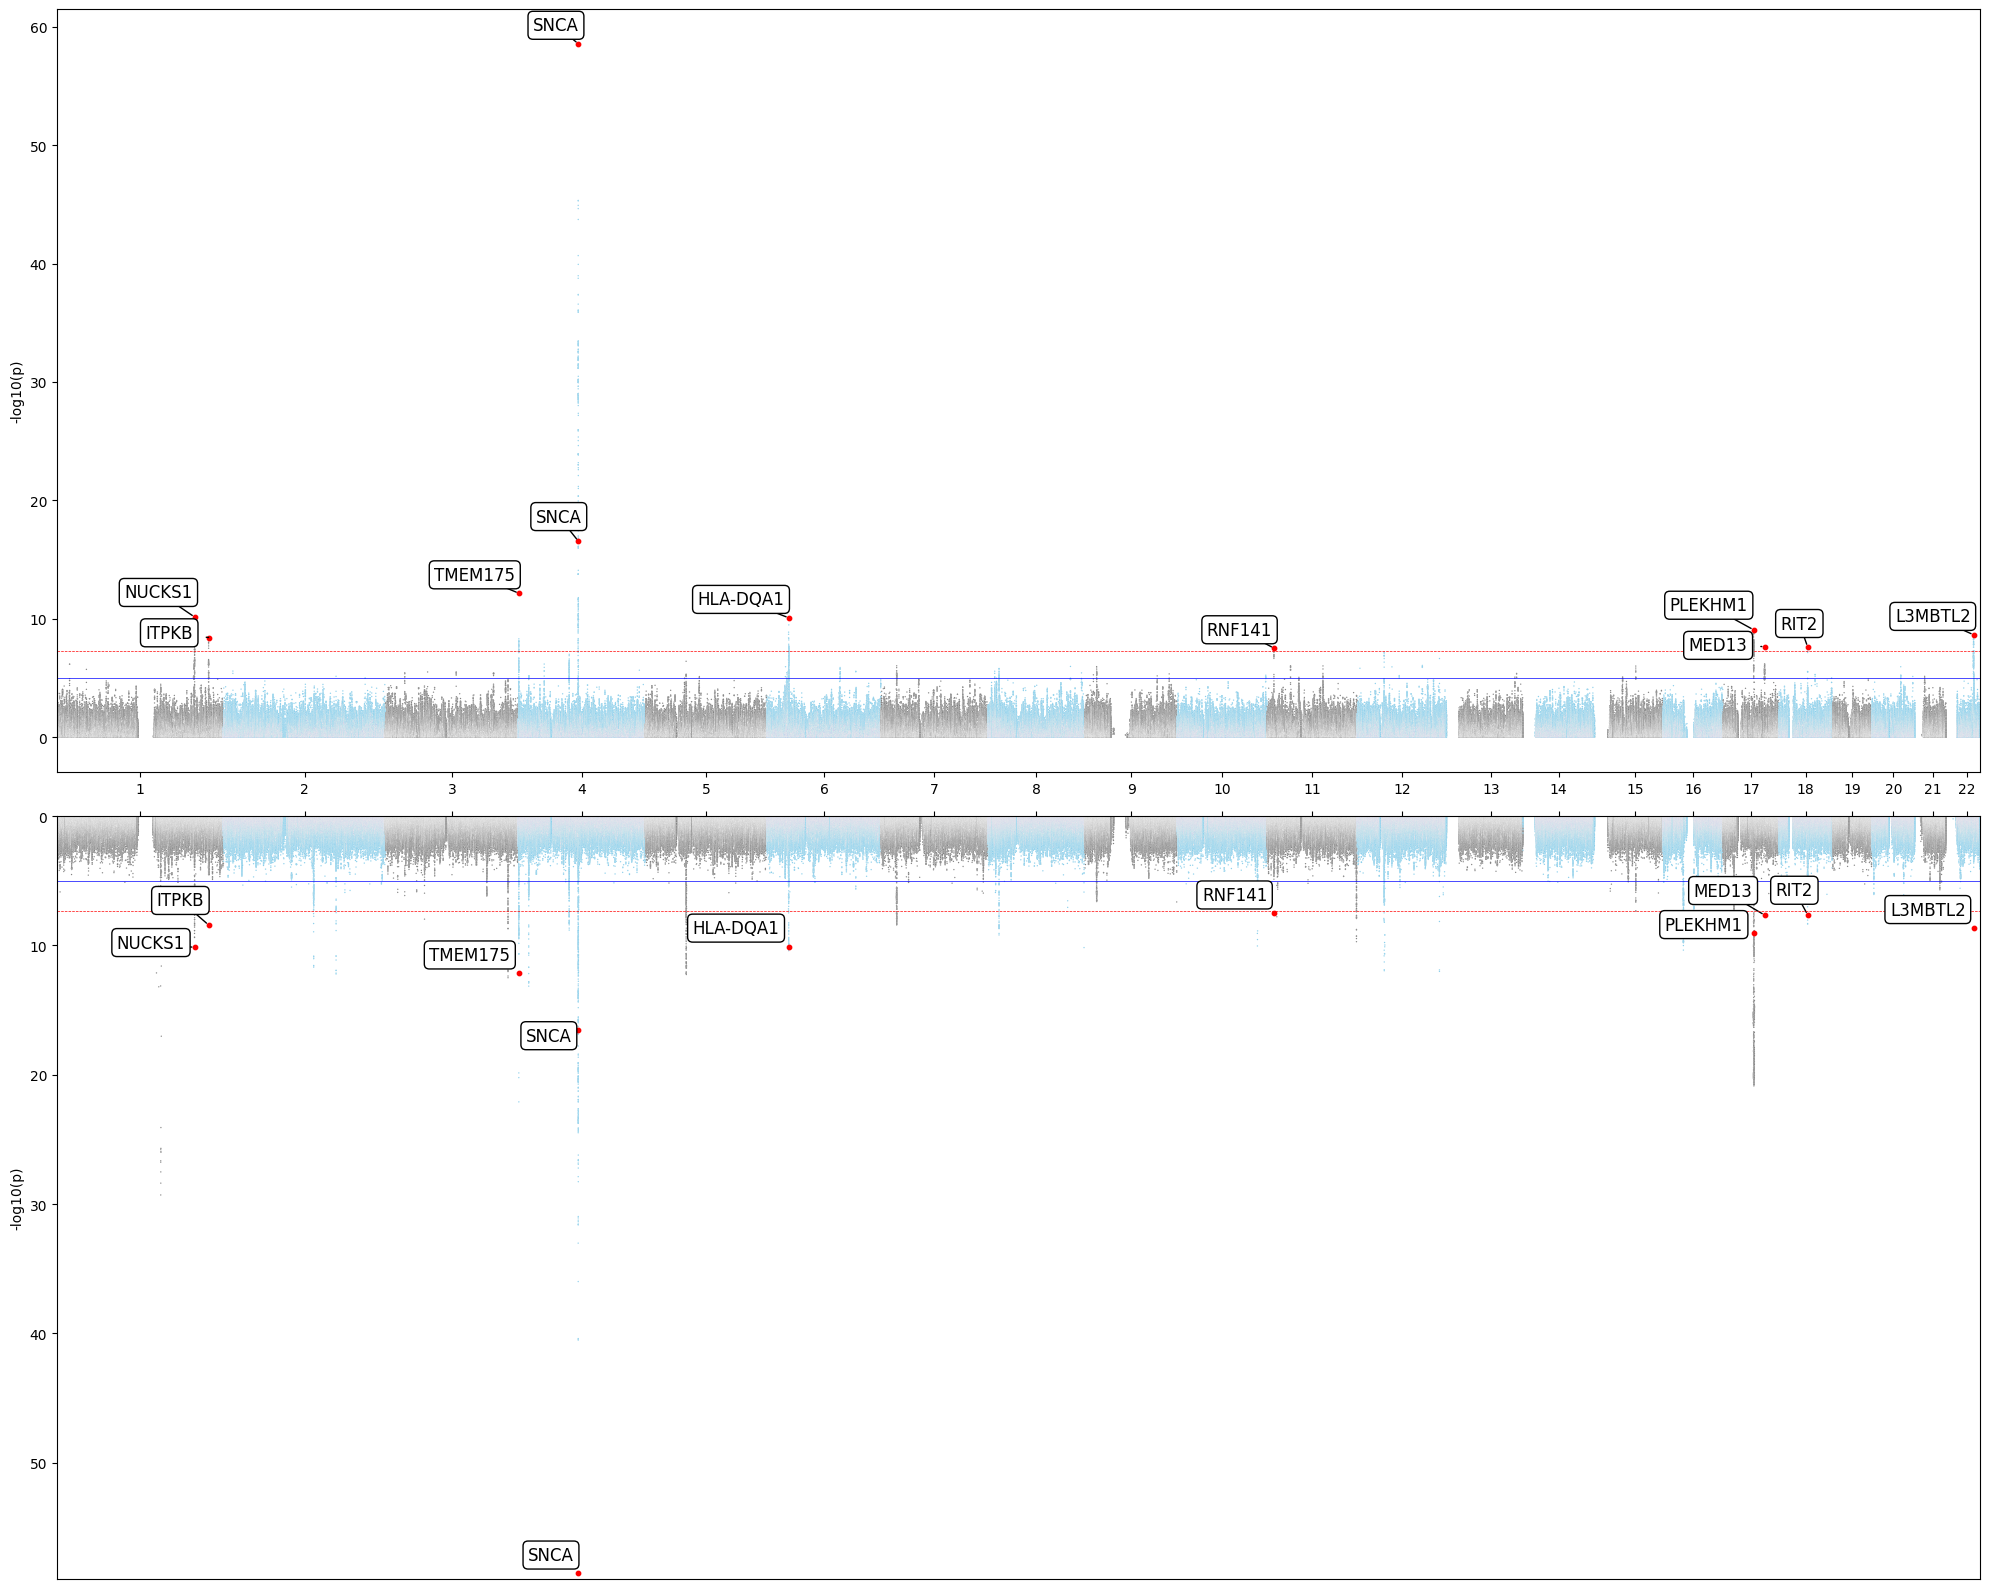

In [4]:
gwas_f_steps = {
    #'train_model': gwas_f.fixed_model_association_analysis,
    #'top_hits'   : gwas_f.get_top_hits,
    #'annotate'   : gwas_f.annotate_top_hits,
    #'plots'      : gwas_f.plot_drawings,
    'one_cohort' : gwas_f.one_cohort_comparison
}

for step in gwas_f_steps.keys():
    gwas_f_steps[step]()

In [7]:
#gwas_r = GWASrandom(
#    input_path = paths['input_directory'],
#    input_name = paths['input_prefix'],
#    output_path= paths['output_directory'],
#    output_name= paths['output_prefix'],
#    config_dict= params,
#    preps_path = os.path.join(paths['output_directory'], 'preparatory'),
#)

*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Nov 15 2022 21:14:25, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 10:24:04 CEST on Fri Sep 13 2024.
Hostname: IKEAB-TS-P3

Options: 
 
--bfile /home/luis/data/testDownStream/outputData/preparatory/ds_results_LDpruned 
--make-grm 
--thread-num 30 
--out /home/luis/data/testDownStream/outputData/gwas_random/ds_results_grm 

The program will be running with up to 30 threads.
Note: GRM is computed using the SNPs on the autosomes.
Reading PLINK FAM file from [/home/luis/data/testDownStream/outputData/preparatory/ds_results_LDpruned.fam]...
466 individuals to be included from FAM file.
466 individuals to be included. 322 males, 144 females, 0 unknown.
Reading PLINK BIM file from [/ho

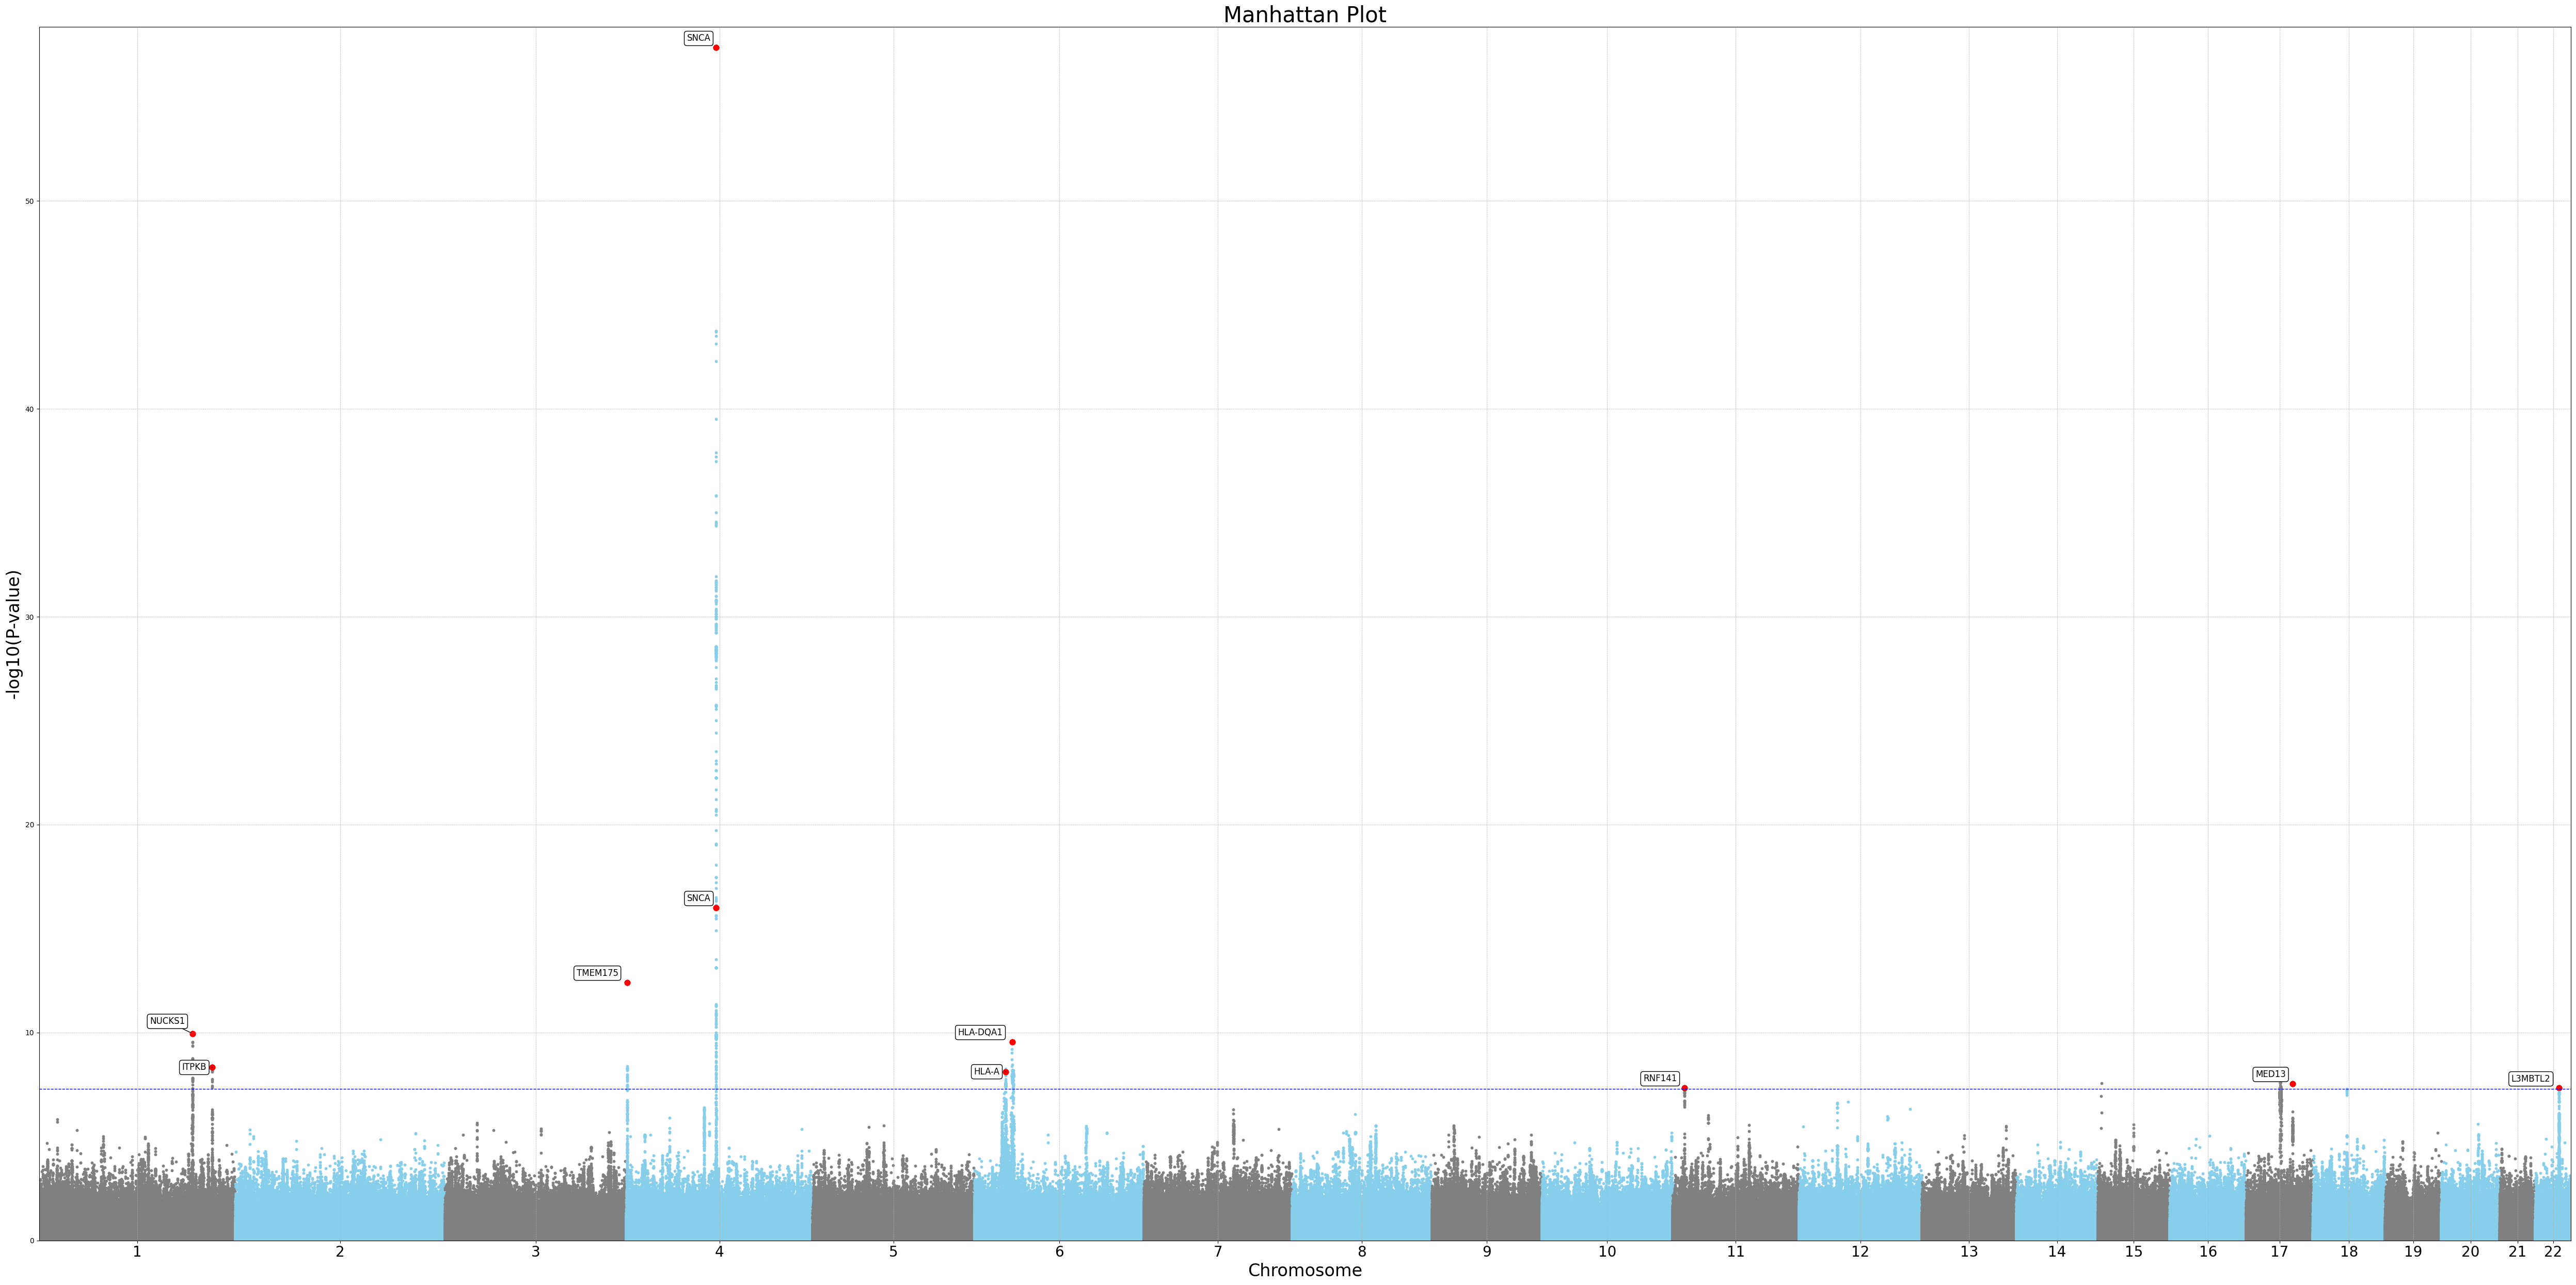

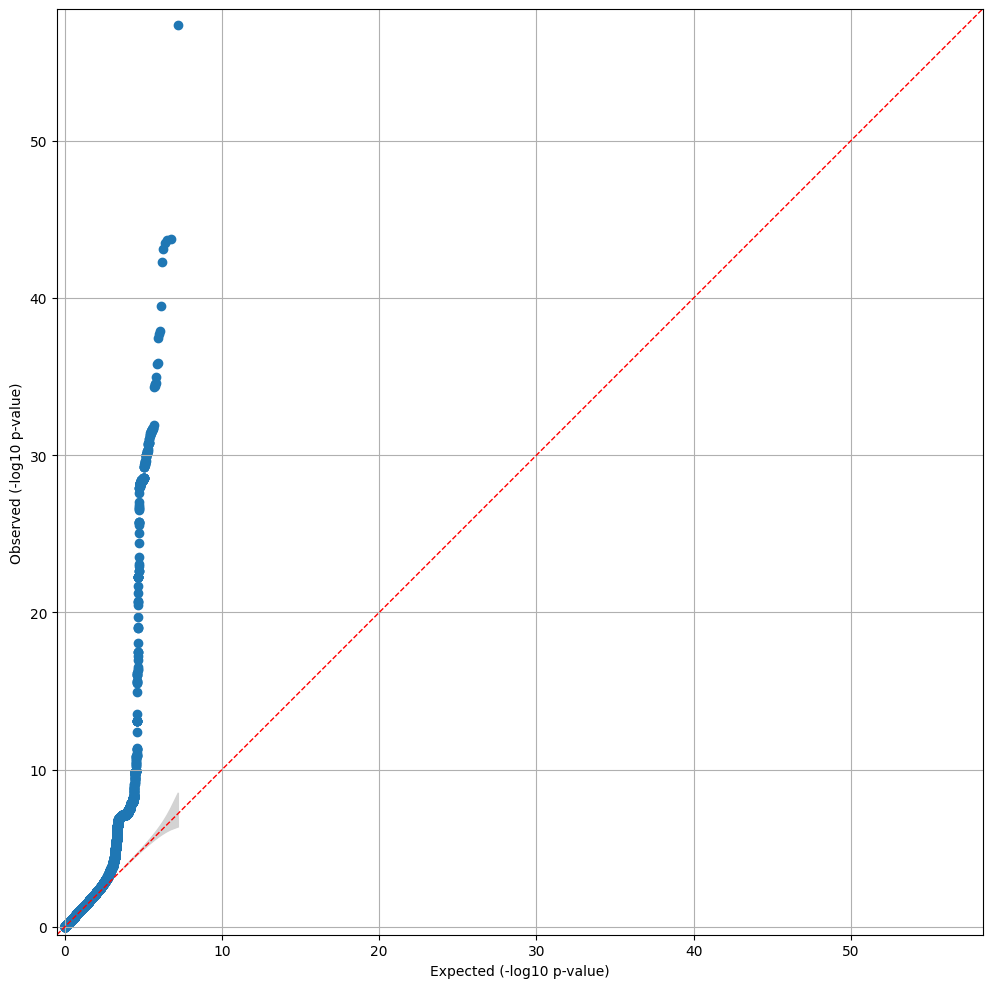

In [8]:
#gwas_r_steps = {
#    'preparatory': gwas_r.prepare_aux_files,
#    'grm'        : gwas_r.compute_grm,
#    'random'     : gwas_r.run_gwas_random,
#    'top_hits'   : gwas_r.get_top_hits,
#    'annotate'   : gwas_r.annotate_top_hits,
#    'plots'      : gwas_r.plot_drawings
#}
#for step in gwas_r_steps.keys():
#    gwas_r_steps[step]()

In [7]:
gwas_f.output_path

'/home/luis/data/LuxGiantimputed/outputData'

In [9]:
import pandas as pd

df_annot = pd.read_csv(
    os.path.join('/home/luis/data/LuxGiantimputed/outputData/gwas_fixed', "snps_annotated.csv"), 
    sep='\t'
)
df_gwas = pd.read_csv(
    os.path.join('/home/luis/data/LuxGiantimputed/outputData/gwas_fixed', "ds_results_glm.PHENO1.glm.logistic.hybrid"), 
    sep='\t'
)

In [11]:
df_gwas[df_gwas['SNP'].isin(df_annot['SNP'])]

,CHR,POS,SNP,A2,ALT,PROVISIONAL_REF,A1,OMITTED,freq,FIRTH,TEST,N,b,se,L95,U95,Z_STAT,p,ERRCODE
359896,1,205708020,rs3747973,G,A,Y,A,G,0.437287,N,ADD,11170,-0.180252,0.027646,-0.234437,-0.126067,-6.52002,7.029820e-11,.
404960,1,226728477,rs74990530,A,T,Y,T,A,0.094942,N,ADD,11170,0.273158,0.046359,0.182296,0.364019,5.89223,3.810230e-09,.
1375536,4,958159,rs34311866,T,C,Y,C,T,0.341987,N,ADD,11170,0.204801,0.028519,0.148905,0.260697,7.18120,6.910290e-13,.
1583985,4,89704960,rs356182,A,G,Y,G,A,0.421979,N,ADD,11170,0.451027,0.027775,0.396589,0.505465,16.23850,2.693180e-59,.
1584336,4,89835399,rs7681440,G,C,Y,C,G,0.402820,N,ADD,11170,-0.236062,0.027914,-0.290772,-0.181353,-8.45688,2.746340e-17,.
2282870,6,32616036,rs1846190,G,A,Y,A,G,0.204969,N,ADD,11170,-0.220423,0.033930,-0.286925,-0.153921,-6.49635,8.229450e-11,.
3858562,11,10521749,rs4909940,C,T,Y,T,C,0.311191,N,ADD,11170,-0.164835,0.029750,-0.223145,-0.106526,-5.54061,3.014140e-08,.
5246682,17,45495053,rs56328224,C,T,Y,T,C,0.051567,N,ADD,11170,-0.393346,0.064096,-0.518971,-0.267720,-6.13682,8.418710e-10,.
5274201,17,62016181,rs72843781,A,C,Y,C,A,0.204342,N,ADD,11170,0.190305,0.034023,0.123621,0.256989,5.59340,2.226630e-08,.
5402754,18,43094076,rs8087199,G,A,Y,A,G,0.420412,N,ADD,11170,0.155191,0.027788,0.100729,0.209654,5.58492,2.338040e-08,.


In [ ]:
df_annot

In [36]:
df_gwas_bottom = pd.read_csv('/home/luis/data/MiamiPlots/nallsEtAl2019_excluding23andMe_allVariants.tab', sep='\t',usecols=['SNP', 'p'], low_memory=False)
df_gwas_bottom['CHR'] = df_gwas_bottom['SNP'].apply(lambda x: int(x.split(':')[0][3:]))
df_gwas_bottom['bp'] = df_gwas_bottom['SNP'].apply(lambda x: int(x.split(':')[1]))
df_gwas_bottom.to_csv('/home/luis/data/MiamiPlots/known_results_hg19.txt', sep='\t', index=False)

In [1]:
from luxgiant_dstream import plots
import pandas as pd